# Project: Analyzing and Visualizing Airbnb Listings in a City

### import libraries

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

### import csv file

In [2]:
df = pd.read_csv("C:/Users/IreOluwa/Desktop/jupyter/albany-airbnb-project/Data/listings.csv")

## Cleaning the data

### Removing null columns

In [3]:
updated_df = df.drop(columns=['license', 'neighbourhood_group'], axis=1)

### Handlng Missing values

In [4]:
updated_df['price'] = updated_df['price'].fillna(updated_df['price'].median())
updated_df['availability_365'] = updated_df['availability_365'].clip(lower=0)
updated_df['reviews_per_month'] = updated_df['reviews_per_month'].fillna(updated_df['reviews_per_month'].mean())
updated_df['last_review'] = updated_df['last_review'].ffill()
updated_df['number_of_reviews_ltm'] = updated_df['number_of_reviews_ltm'].fillna(updated_df['number_of_reviews_ltm'].median())

### Correcting Data Type

In [5]:
updated_df['last_review'] = pd.to_datetime(updated_df['last_review'], format='%Y-%m-%d', errors='coerce')
updated_df['neighbourhood'] = updated_df['neighbourhood'].astype('category')
updated_df['room_type'] = updated_df['room_type'].astype('category')
updated_df['availability_365'] = pd.to_numeric(updated_df['availability_365'], errors='coerce')
updated_df['number_of_reviews'] = pd.to_numeric(updated_df['number_of_reviews'], errors='coerce')
updated_df['price'] = pd.to_numeric(updated_df['price'].replace('[$]', '', regex=True).astype(float))

### Handling Outliers

In [6]:
# Calculate IQR for price
upper_limit = updated_df['price'].quantile(0.95)
cleaned_df = updated_df[updated_df['price'] <= upper_limit]
updated_df = cleaned_df.copy()

# Calculate IQR for number_of_reviews
upper_limit = updated_df['number_of_reviews'].quantile(0.95)
cleaned_df = updated_df[updated_df['number_of_reviews'] <= upper_limit]
updated_df = cleaned_df.copy()

### Binning Categorical Data

In [7]:
labels = ['Budget', 'Mid-Range', 'Luxury']
updated_df['price_category'] = pd.cut(updated_df['price'], bins=[0, 100, 175, np.inf], labels=labels)
updated_df['price_category'] = updated_df['price_category'].astype('category')
updated_df['price_category'].value_counts()

price_category
Budget       248
Mid-Range    124
Luxury        30
Name: count, dtype: int64

## Exploratory Data Analysis

In [8]:
updated_df.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,price_category
0,2992450,Luxury 2 bedroom apartment,4621559,Kenneth,THIRD WARD,42.65789,-73.75370,Entire home/apt,70.0,28,9,2022-08-17,0.07,1,70,0,Budget
8,11639446,$55twin($30 foreign student)FreeBF Noa/c no smoke,61700428,Abdullah,ELEVENTH WARD,42.67583,-73.78297,Private room,55.0,15,231,2024-02-29,2.10,2,365,0,Budget
9,12799126,Private Room in the Hearth of the Albany,69729286,Musab,SIXTH WARD,42.65154,-73.76867,Private room,47.0,5,28,2024-02-06,0.48,2,344,0,Budget
10,13083497,Pristine Cape Cod on the Creek - 4 Large Bedrooms,1364123,Akhilesh,FIFTEENTH WARD,42.66972,-73.82753,Entire home/apt,219.0,2,189,2025-05-10,1.74,1,306,12,Luxury
12,15580397,Alb Medical/Dtwn Albany/Colleges ROOM H,89705052,Share,NINTH WARD,42.65651,-73.77887,Private room,52.0,2,48,2025-02-27,0.49,2,115,8,Budget


#### Relationship Between Prices and Neighbourhood

In [9]:
price_stats = updated_df.groupby(['neighbourhood', 'room_type'], observed=True)['price'].size().unstack(fill_value=0)
prices = updated_df.groupby(['neighbourhood', 'room_type'], observed=True)['price'].agg(['min', 'max']).round(2)
price_stats_2 = updated_df.groupby(['neighbourhood', 'price_category'], observed=True)['price'].mean().unstack(fill_value=0).round(2)
avg_price_stats = updated_df.groupby(['neighbourhood', 'room_type'], observed=True)['price'].mean().round(2)
avg_price_stats2 = updated_df.groupby('neighbourhood', observed=True)['price'].mean().round(2)
price_summary1 = updated_df.groupby(['neighbourhood', 'room_type'], observed=True)['price'].agg(['size', 'min', 'max', 'mean']).round(2)
price_summary2 = updated_df.groupby(['neighbourhood', 'price_category'], observed=True)['price'].agg(['size', 'min', 'max', 'mean']).round(2)
price_stats_2

price_category,Budget,Mid-Range,Luxury
neighbourhood,,,
EIGHTH WARD,93.00,154.50,222.50
ELEVENTH WARD,55.22,122.17,0.00
FIFTEENTH WARD,60.75,141.29,227.75
FIFTH WARD,73.33,115.50,0.00
FIRST WARD,94.00,117.00,203.00
FOURTEENTH WARD,65.00,128.33,216.00
FOURTH WARD,85.50,111.43,214.00
NINTH WARD,66.05,135.50,183.00
SECOND WARD,82.05,124.71,193.75


#### Neighbourhood and RoomType vs Price Category and Price

In [10]:
max_price_by_category = updated_df.groupby(['price_category', 'neighbourhood'], observed=True)['price'].max().reset_index()
highest_prices = max_price_by_category.loc[max_price_by_category.groupby('price_category', observed=True)['price'].idxmax()]
highest_prices = highest_prices.merge(updated_df[['neighbourhood', 'room_type', 'price']], on=['neighbourhood', 'price'], how='left')
print("\nWards with the highest price in each price category")
print(highest_prices[['neighbourhood', 'room_type', 'price_category', 'price']])

min_price_by_category = updated_df.groupby(['price_category', 'neighbourhood'], observed=True)['price'].min().reset_index()
lowest_prices = min_price_by_category.loc[min_price_by_category.groupby('price_category', observed=True)['price'].idxmin()]
lowest_prices = lowest_prices.merge(updated_df[['neighbourhood', 'room_type', 'price']], on=['neighbourhood', 'price'], how='left')
print("\nWards with the lowest price in each price category")
print(lowest_prices[['neighbourhood', 'room_type', 'price_category', 'price']])


Wards with the highest price in each price category
     neighbourhood        room_type price_category  price
0  FOURTEENTH WARD  Entire home/apt         Budget  100.0
1      SECOND WARD  Entire home/apt      Mid-Range  174.0
2      EIGHTH WARD  Entire home/apt         Luxury  257.0

Wards with the lowest price in each price category
  neighbourhood        room_type price_category  price
0    NINTH WARD     Private room         Budget   24.0
1    SIXTH WARD  Entire home/apt      Mid-Range  101.0
2    SIXTH WARD  Entire home/apt      Mid-Range  101.0
3    TENTH WARD  Entire home/apt         Luxury  178.0


#### Min and Max Prices and Average Prices of Neighbourhood (Ward)

In [11]:
# Min and Max Price of the Neighbourhood
cheapest_avg_ward = avg_price_stats2.idxmin()
cheapest_avg_price = avg_price_stats2.min()

most_expensive_avg_ward = avg_price_stats2.idxmax()
most_expensive_avg_price = avg_price_stats2.max()

print(f"cheapest ward: {cheapest_avg_ward}, average price: ${cheapest_avg_price:.2f}")
print(f"most expensive ward: {most_expensive_avg_ward}, average price: ${most_expensive_avg_price:.2f}")

# Min and Max Price of the Neighbourhood by RoomType
cheapest_avg_ward = avg_price_stats.idxmin()
cheapest_avg_price = avg_price_stats.min()

most_expensive_avg_ward = avg_price_stats.idxmax()
most_expensive_avg_price = avg_price_stats.max()

print(f"\ncheapest ward by room type: {cheapest_avg_ward}, average price: ${cheapest_avg_price:.2f}")
print(f"most expensive ward by room type: {most_expensive_avg_ward}, average price: ${most_expensive_avg_price:.2f}")


cheapest ward: ELEVENTH WARD, average price: $71.96
most expensive ward: EIGHTH WARD, average price: $184.57

cheapest ward by room type: ('SEVENTH WARD', 'Private room'), average price: $50.00
most expensive ward by room type: ('EIGHTH WARD', 'Entire home/apt'), average price: $199.83


#### Availability of each Neighbourhood by RoomType

In [12]:
avail_room_stats = updated_df.groupby(['neighbourhood', 'room_type'], observed=True)['availability_365'].mean().round(2)

min_avail_room = avail_room_stats.idxmin()
min_avail_details = avail_room_stats.min()
print(f"The least available room is: {min_avail_room}, Availability: {min_avail_details:.0f}")

max_avail_room = avail_room_stats.idxmax()
max_avail_details = avail_room_stats.max()
print(f"The most available room is: {max_avail_room}, Availability: {max_avail_details:.0f}")

The least available room is: ('EIGHTH WARD', 'Private room'), Availability: 0
The most available room is: ('FIFTH WARD', 'Private room'), Availability: 364


In [13]:
avail_room_stats

neighbourhood    room_type      
EIGHTH WARD      Entire home/apt    243.50
                 Private room         0.00
ELEVENTH WARD    Entire home/apt    262.57
                 Private room       291.80
FIFTEENTH WARD   Entire home/apt    272.00
                 Private room       131.25
FIFTH WARD       Entire home/apt    279.33
                 Private room       364.50
FIRST WARD       Entire home/apt    219.33
FOURTEENTH WARD  Entire home/apt    223.50
                 Private room       186.67
FOURTH WARD      Entire home/apt    169.43
                 Private room       201.50
NINTH WARD       Entire home/apt    255.87
                 Private room       238.31
SECOND WARD      Entire home/apt    168.31
                 Private room       205.17
SEVENTH WARD     Entire home/apt    223.89
                 Private room       228.00
SIXTH WARD       Entire home/apt    226.68
                 Private room       225.38
TENTH WARD       Entire home/apt    220.00
                 Priv

##### Availability of each RoomType by Price Category

In [14]:
avail_room_price = updated_df.groupby(['room_type', 'price_category'], observed=True)['availability_365'].mean().round(2)

min_avail_room_price = avail_room_price.idxmin()
min_avail_price = avail_room_price.min()
print(f"The least available room by price category is: {min_avail_room_price}, Availability: {min_avail_price:.0f}")

max_avail_room_price = avail_room_price.idxmax()
max_avail_price = avail_room_price.max()
print(f"The most available room by price category is: {max_avail_room_price}, Availability: {max_avail_price:.0f}")

The least available room by price category is: ('Private room', 'Luxury'), Availability: 12
The most available room by price category is: ('Entire home/apt', 'Luxury'), Availability: 239


##### Availability of each Neighbourhood

In [15]:
avail_ward_stats = updated_df.groupby('neighbourhood', observed=True)['availability_365'].mean().round(0)

min_avg_avail_ward = avail_ward_stats.idxmin()
min_avg_avail_ward_details = avail_ward_stats.min()

max_avg_avail_ward = avail_ward_stats.idxmax()
max_avg_avail_details = avail_ward_stats.max()

print(f"\nThe least available ward (Avg) is: {min_avg_avail_ward}, Availability: {min_avg_avail_ward_details}")
print(f"The most available ward (Avg) is: {max_avg_avail_ward}, Availability: {max_avg_avail_details}")


The least available ward (Avg) is: FOURTH WARD, Availability: 173.0
The most available ward (Avg) is: FIFTH WARD, Availability: 301.0


In [16]:
avail_ward_stats

neighbourhood
EIGHTH WARD        209.0
ELEVENTH WARD      275.0
FIFTEENTH WARD     234.0
FIFTH WARD         301.0
FIRST WARD         219.0
FOURTEENTH WARD    203.0
FOURTH WARD        173.0
NINTH WARD         247.0
SECOND WARD        174.0
SEVENTH WARD       224.0
SIXTH WARD         226.0
TENTH WARD         212.0
THIRD WARD         253.0
THIRTEENTH WARD    214.0
TWELFTH WARD       236.0
Name: availability_365, dtype: float64

In [17]:
df[df['neighbourhood'] == 'FIRST WARD']['room_type'].value_counts()

room_type
Entire home/apt    10
Name: count, dtype: int64

#### Number of Reviews (Avg)

In [18]:
review_summary = updated_df.groupby(['neighbourhood', 'room_type'], observed=True)['number_of_reviews'].agg(['size', 'min', 'max', 'mean']).round(2)
review_stats = updated_df.groupby(['neighbourhood', 'room_type'], observed=True)['number_of_reviews'].mean().round(2)


print(f"\nMost Reviewed Neighbourhood: {review_stats.idxmax()}, Reviews={review_stats.max()}")
print(f"\nLeast Reviewed Neighbourhood: {review_stats.idxmin()}. Reviews={review_stats.min()}")


Most Reviewed Neighbourhood: ('EIGHTH WARD', 'Private room'), Reviews=213.0

Least Reviewed Neighbourhood: ('TWELFTH WARD', 'Private room'). Reviews=1.0


In [19]:
review_summary

size  min  max    mean
neighbourhood   room_type                              
EIGHTH WARD     Entire home/apt     6    0   91   28.67
                Private room        1  213  213  213.00
ELEVENTH WARD   Entire home/apt    14    0  185   30.50
                Private room       10    2  231   43.20
FIFTEENTH WARD  Entire home/apt    11    0  189   51.00
                Private room        4    6   46   23.75
FIFTH WARD      Entire home/apt     6    2   36   14.33
                Private room        2    0  132   66.00
FIRST WARD      Entire home/apt     9    0  115   23.89
FOURTEENTH WARD Entire home/apt    10    1  158   59.20
                Private room       12    0  187   62.08
FOURTH WARD     Entire home/apt    14    0  173   46.86
                Private room        2    1    7    4.00
NINTH WARD      Entire home/apt    15    0  232   65.13
                Private room       16    0  121   34.19
SECOND WARD     Entire home/apt    32    0  144   43.97
                Private room        6    0  174   36.50
SEVENTH WARD    Entire home/apt    18    1  131   23.56
                Private room        1  198  198  198.00
SIXTH WARD      Entire home/apt    76    0  243   45.50
                Private room       13    0   92   13.54
TENTH WARD      Entire home/apt    18    0  181   57.94
                Private room       24    0   31    2.96
THIRD WARD      Entire home/apt    31    0  255   34.06
                Private room        5    0   29   12.60
THIRTEENTH WARD Entire home/apt    20    3  130   42.35
                Private room       19    0  172   34.63
TWELFTH WARD    Entire home/apt     6    0   24    9.67
                Private room        1    1    1    1.00

##### Monthly Reviews (Avg)

In [20]:
monthly_review_summary = updated_df.groupby(['neighbourhood', 'room_type'], observed=True)['reviews_per_month'].agg(['size', 'min', 'max', 'mean']).round(2)
monthly_review_stats = updated_df.groupby(['neighbourhood', 'room_type'], observed=True)['reviews_per_month'].mean().round(2)


print(f"\nMost reviewed ward per month: {monthly_review_stats.idxmax()}, Reviews= {monthly_review_stats.max()}")
print(f"\nLeast reviewed ward per month: {monthly_review_stats.idxmin()}, Reviews= {monthly_review_stats.min()}")


Most reviewed ward per month: ('EIGHTH WARD', 'Private room'), Reviews= 2.78

Least reviewed ward per month: ('FOURTH WARD', 'Private room'), Reviews= 0.11


##### Number of reviews ltm (Last 12 Months)

In [21]:
reviews_ltm_stats = updated_df.groupby('neighbourhood', observed=True).agg({'number_of_reviews_ltm' : ['sum', 'mean']}).round(2)
reviews_ltm_stats.columns = ['total_reviews_ltm', 'avg_reviews_ltm']
reviews_ltm_stats = reviews_ltm_stats.sort_values('total_reviews_ltm', ascending=False)

reviews_ltm_stats

,total_reviews_ltm,avg_reviews_ltm
neighbourhood,,
SIXTH WARD,1474,16.56
SECOND WARD,627,16.50
THIRTEENTH WARD,568,14.56
NINTH WARD,393,12.68
FOURTEENTH WARD,377,17.14
TENTH WARD,330,7.86
THIRD WARD,282,7.83
ELEVENTH WARD,276,11.50
FIFTEENTH WARD,263,17.53


In [22]:
top_reviews_ltm = reviews_ltm_stats['total_reviews_ltm'].idxmax()
least_reviews_ltm = reviews_ltm_stats['total_reviews_ltm'].idxmin()

print(f"The ward with the least reviews in the last 12 months is: {least_reviews_ltm}, Total reviews: {reviews_ltm_stats['total_reviews_ltm'].min()}")
print(f"The ward with the most reviews in the last 12 months is: {top_reviews_ltm}, Total review is: {reviews_ltm_stats['total_reviews_ltm'].max()}")

The ward with the least reviews in the last 12 months is: FIFTH WARD, Total reviews: 24
The ward with the most reviews in the last 12 months is: SIXTH WARD, Total review is: 1474


In [23]:
reviews_ltm_price = updated_df.groupby('neighbourhood', observed=True).agg({'number_of_reviews_ltm' : 'sum', 'availability_365' : 'mean'}).round(2)
reviews_ltm_price.columns = ['total_reviews_ltm', 'avg_availability']
reviews_ltm_price = reviews_ltm_price.sort_values('total_reviews_ltm', ascending=False)
reviews_ltm_price


,total_reviews_ltm,avg_availability
neighbourhood,,
SIXTH WARD,1474,226.49
SECOND WARD,627,174.13
THIRTEENTH WARD,568,214.33
NINTH WARD,393,246.81
FOURTEENTH WARD,377,203.41
TENTH WARD,330,212.38
THIRD WARD,282,253.25
ELEVENTH WARD,276,274.75
FIFTEENTH WARD,263,234.47


#### Minimun Nights spent (Avg)

In [24]:
nights_stats = updated_df.groupby(['neighbourhood', 'room_type'], observed=True)['minimum_nights'].mean().round(0)
nights_summary = updated_df.groupby(['neighbourhood', 'room_type'], observed=True)['minimum_nights'].agg(Count='size', Min= 'min', Max= 'max', Average_night_spent= 'mean').round(0)

print(f"Most Night spent in a Neighbourhood: {nights_stats.idxmax()}, Nights: {nights_stats.max()}")
print(f"Least Night spent in a Neighbourhood: {nights_stats.idxmin()}, Nights: {nights_stats.min()}")

Most Night spent in a Neighbourhood: ('TWELFTH WARD', 'Entire home/apt'), Nights: 64.0
Least Night spent in a Neighbourhood: ('EIGHTH WARD', 'Private room'), Nights: 1.0


In [25]:
nights_summary

Count  Min  Max  Average_night_spent
neighbourhood   room_type                                            
EIGHTH WARD     Entire home/apt      6    2   13                  6.0
                Private room         1    1    1                  1.0
ELEVENTH WARD   Entire home/apt     14    1   31                  3.0
                Private room        10    1   18                  7.0
FIFTEENTH WARD  Entire home/apt     11    1   30                  7.0
                Private room         4    2    3                  3.0
FIFTH WARD      Entire home/apt      6    1    3                  2.0
                Private room         2    1   15                  8.0
FIRST WARD      Entire home/apt      9    1   30                  7.0
FOURTEENTH WARD Entire home/apt     10    1   14                  4.0
                Private room        12    1   28                  4.0
FOURTH WARD     Entire home/apt     14    1   30                  4.0
                Private room         2    1    3                  2.0
NINTH WARD      Entire home/apt     15    1   70                  9.0
                Private room        16    1    5                  2.0
SECOND WARD     Entire home/apt     32    1   14                  3.0
                Private room         6    1    2                  1.0
SEVENTH WARD    Entire home/apt     18    1   28                  5.0
                Private room         1    1    1                  1.0
SIXTH WARD      Entire home/apt     76    1   60                  6.0
                Private room        13    1    5                  2.0
TENTH WARD      Entire home/apt     18    1   28                  4.0
                Private room        24    1   30                 19.0
THIRD WARD      Entire home/apt     31    1   31                 12.0
                Private room         5    1   30                  7.0
THIRTEENTH WARD Entire home/apt     20    1   60                  6.0
                Private room        19    1   30                 11.0
TWELFTH WARD    Entire home/apt      6    2  365                 64.0
                Private room         1    2    2                  2.0

#### Correlation between number_of_reviews and price or availability_365?

In [26]:
correlation = df[['price', 'number_of_reviews', 'availability_365']].corr()
correlation

,price,number_of_reviews,availability_365
price,1.000000,-0.075125,0.064000
number_of_reviews,-0.075125,1.000000,-0.007824
availability_365,0.064000,-0.007824,1.000000


## Visualizations

### Correlations

#### HeatMap showing all Correlations

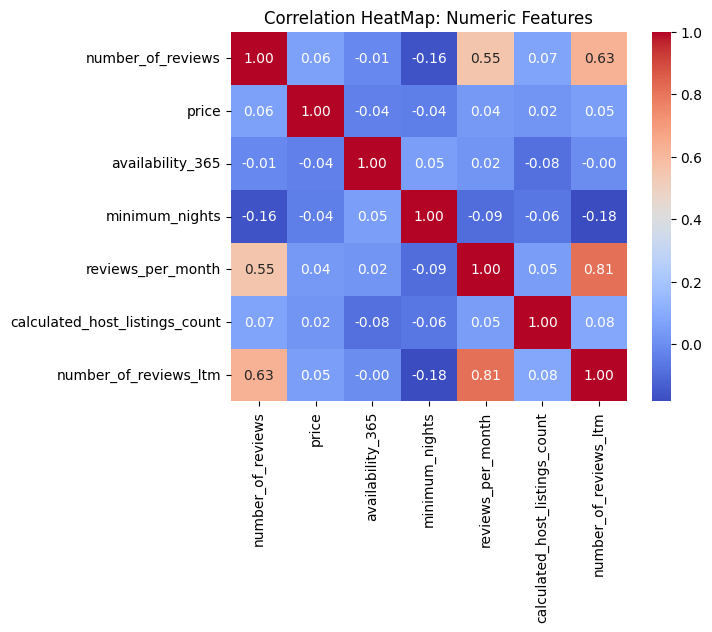

In [27]:
selected_columns = updated_df[['number_of_reviews', 'price', 'availability_365', 'minimum_nights', 'reviews_per_month', 'calculated_host_listings_count', 'number_of_reviews_ltm']]
sns.heatmap(data=selected_columns.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.xticks(rotation=90)
plt.title('Correlation HeatMap: Numeric Features')
plt.show()

### BarPlot: Price vs Neighbourhood (Avg)

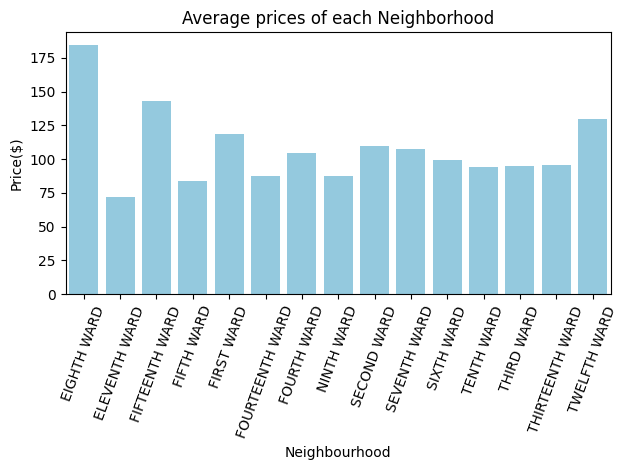

<Figure size 2000x1000 with 0 Axes>

In [28]:
sns.barplot(x='neighbourhood', y='price', color='skyblue', data=updated_df, errorbar=None)
plt.title('Average prices of each Neighborhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Price($)')
plt.xticks(rotation=70)
plt.tight_layout()
plt.figure(figsize=(20, 10))
#plt.savefig("C:/Users/IreOluwa/Desktop/jupyter/albany-airbnb-project/outputs/Average_price_neighbourhood.png")
plt.show()

#### Average Price of each Neighbourhood by Room Type

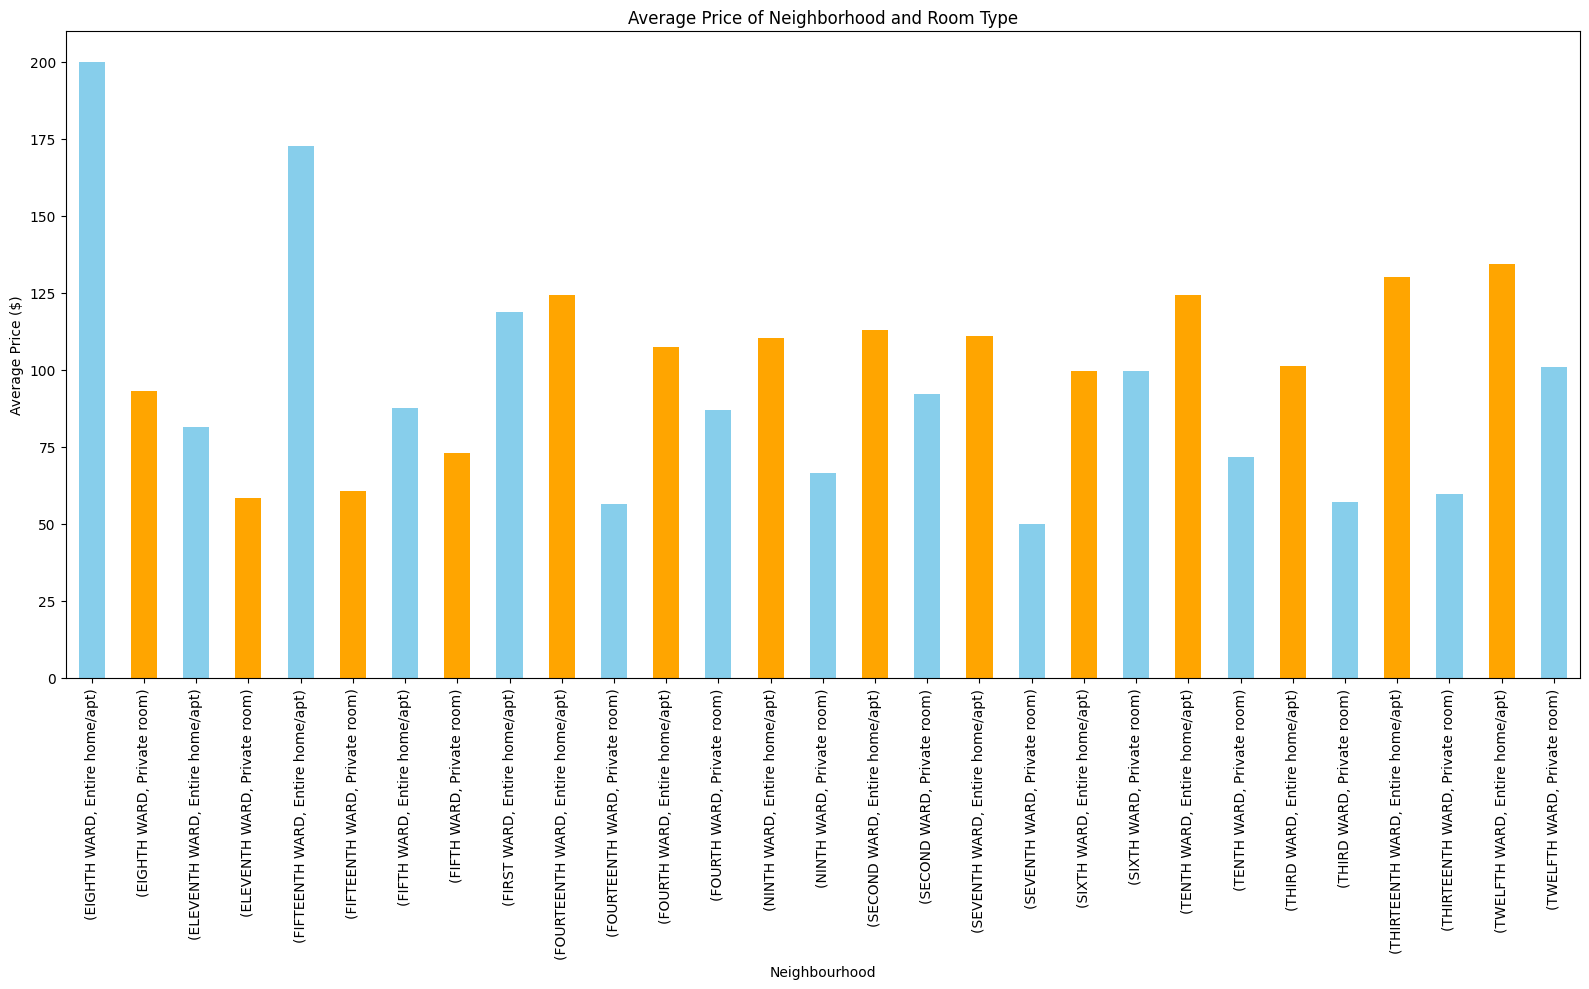

In [29]:
avg_price_stats.plot(kind='bar', figsize=(16, 10), color=['skyblue', 'orange'])
plt.title('Average Price of Neighborhood and Room Type')
plt.xlabel('Neighbourhood')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Avg Price of each Room Type

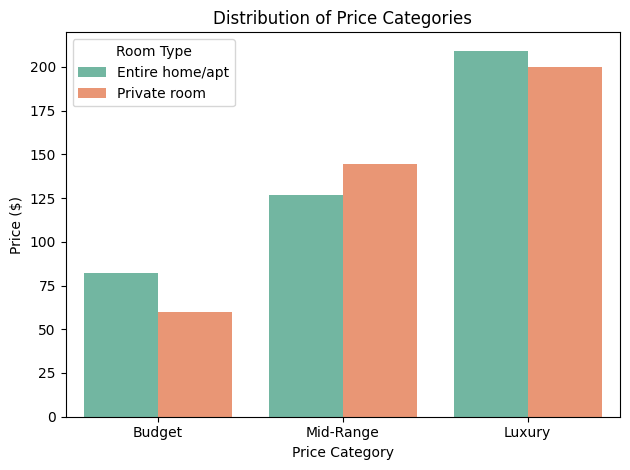

In [30]:
sns.barplot(x='price_category', y='price', hue='room_type', data=updated_df, palette='Set2', errorbar=None)
plt.title('Distribution of Price Categories')
plt.xlabel('Price Category')
plt.ylabel('Price ($)')
plt.legend(title='Room Type')
plt.tight_layout()
plt.show()

#### Number of reviews vs Neighbourhood (Avg)

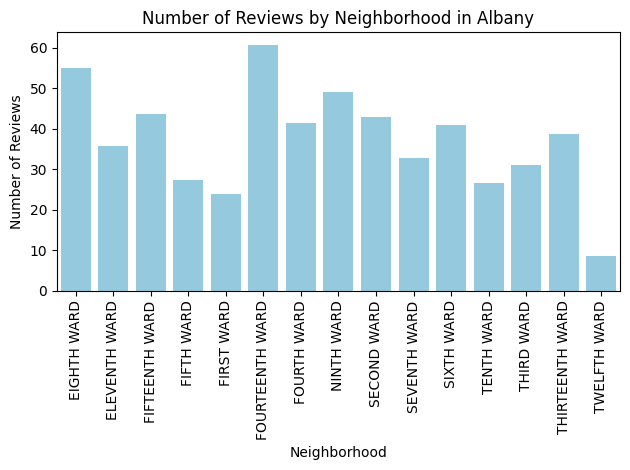

In [31]:
sns.barplot(x='neighbourhood', y='number_of_reviews', color='skyblue', data=updated_df, errorbar=None)
plt.title('Number of Reviews by Neighborhood in Albany')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Number of reviews vs Neighbourhood (Avg) By room type

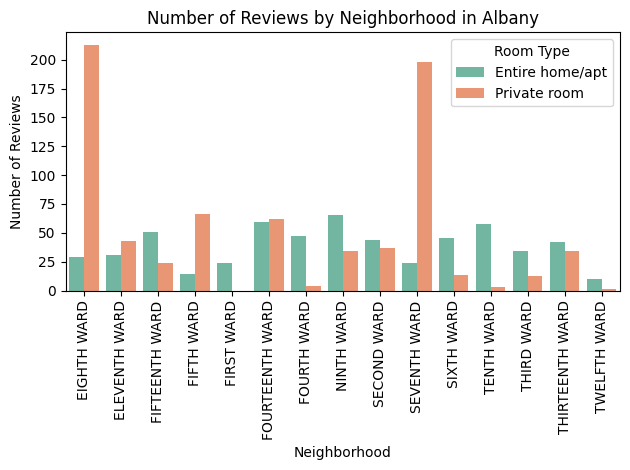

In [32]:
sns.barplot(x='neighbourhood', y='number_of_reviews', hue='room_type', palette='Set2', data=updated_df, errorbar=None)
plt.title('Number of Reviews by Neighborhood in Albany')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=90)
plt.legend(title='Room Type')
plt.tight_layout()
#plt.savefig('reviews_by_neighbourhood_RoomType.png')
plt.show()

#### Monthly reviews vs Neighbourhood

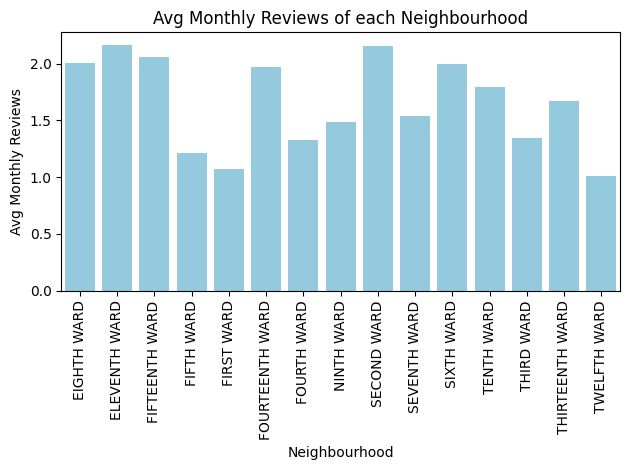

In [33]:
sns.barplot(x='neighbourhood', y='reviews_per_month', data=updated_df, color='skyblue', errorbar=None)
plt.title('Avg Monthly Reviews of each Neighbourhood')
plt.xlabel('Neighbourhood')
plt.xticks(rotation=90)
plt.ylabel('Avg Monthly Reviews')
plt.tight_layout()
plt.savefig('Monthly Reviews of Neighbourhood.png')
plt.show()

#### Monthly reviews vs Neighbourhood by RoomType

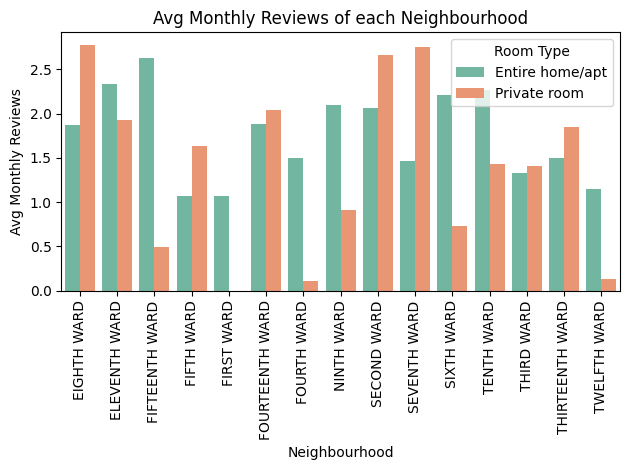

In [34]:
sns.barplot(x='neighbourhood', y='reviews_per_month', data=updated_df, hue='room_type', palette='Set2', errorbar=None)
plt.title('Avg Monthly Reviews of each Neighbourhood')
plt.xlabel('Neighbourhood')
plt.xticks(rotation=90)
plt.ylabel('Avg Monthly Reviews')
plt.legend(title='Room Type')
plt.tight_layout()
plt.show()

#### Reviews in the last 12 months

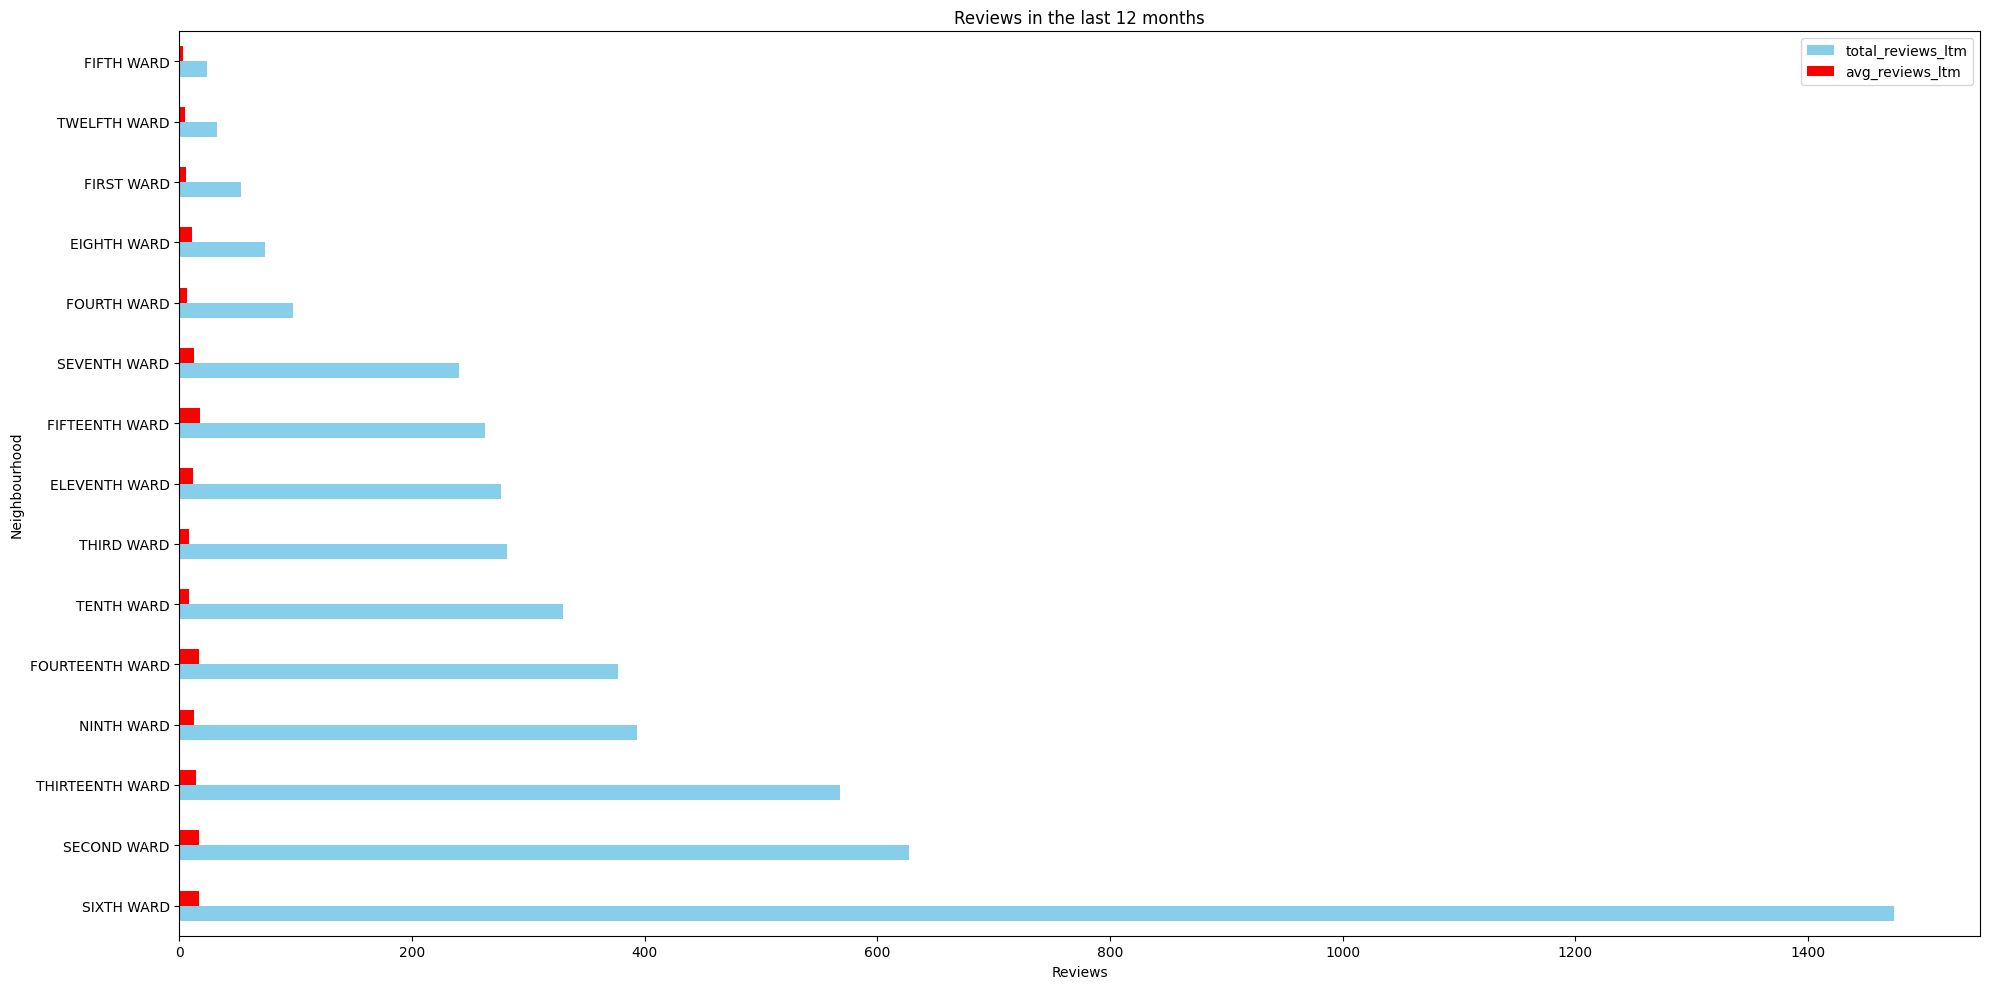

In [35]:
reviews_ltm_stats.plot(kind='barh', figsize=(20, 10), color=['skyblue', 'red'])
plt.title('Reviews in the last 12 months')
plt.xlabel('Reviews')
plt.ylabel('Neighbourhood')
plt.tight_layout()
plt.show()

##### Total Reviews in the last 12 months vs Availability of each ward (Avg)

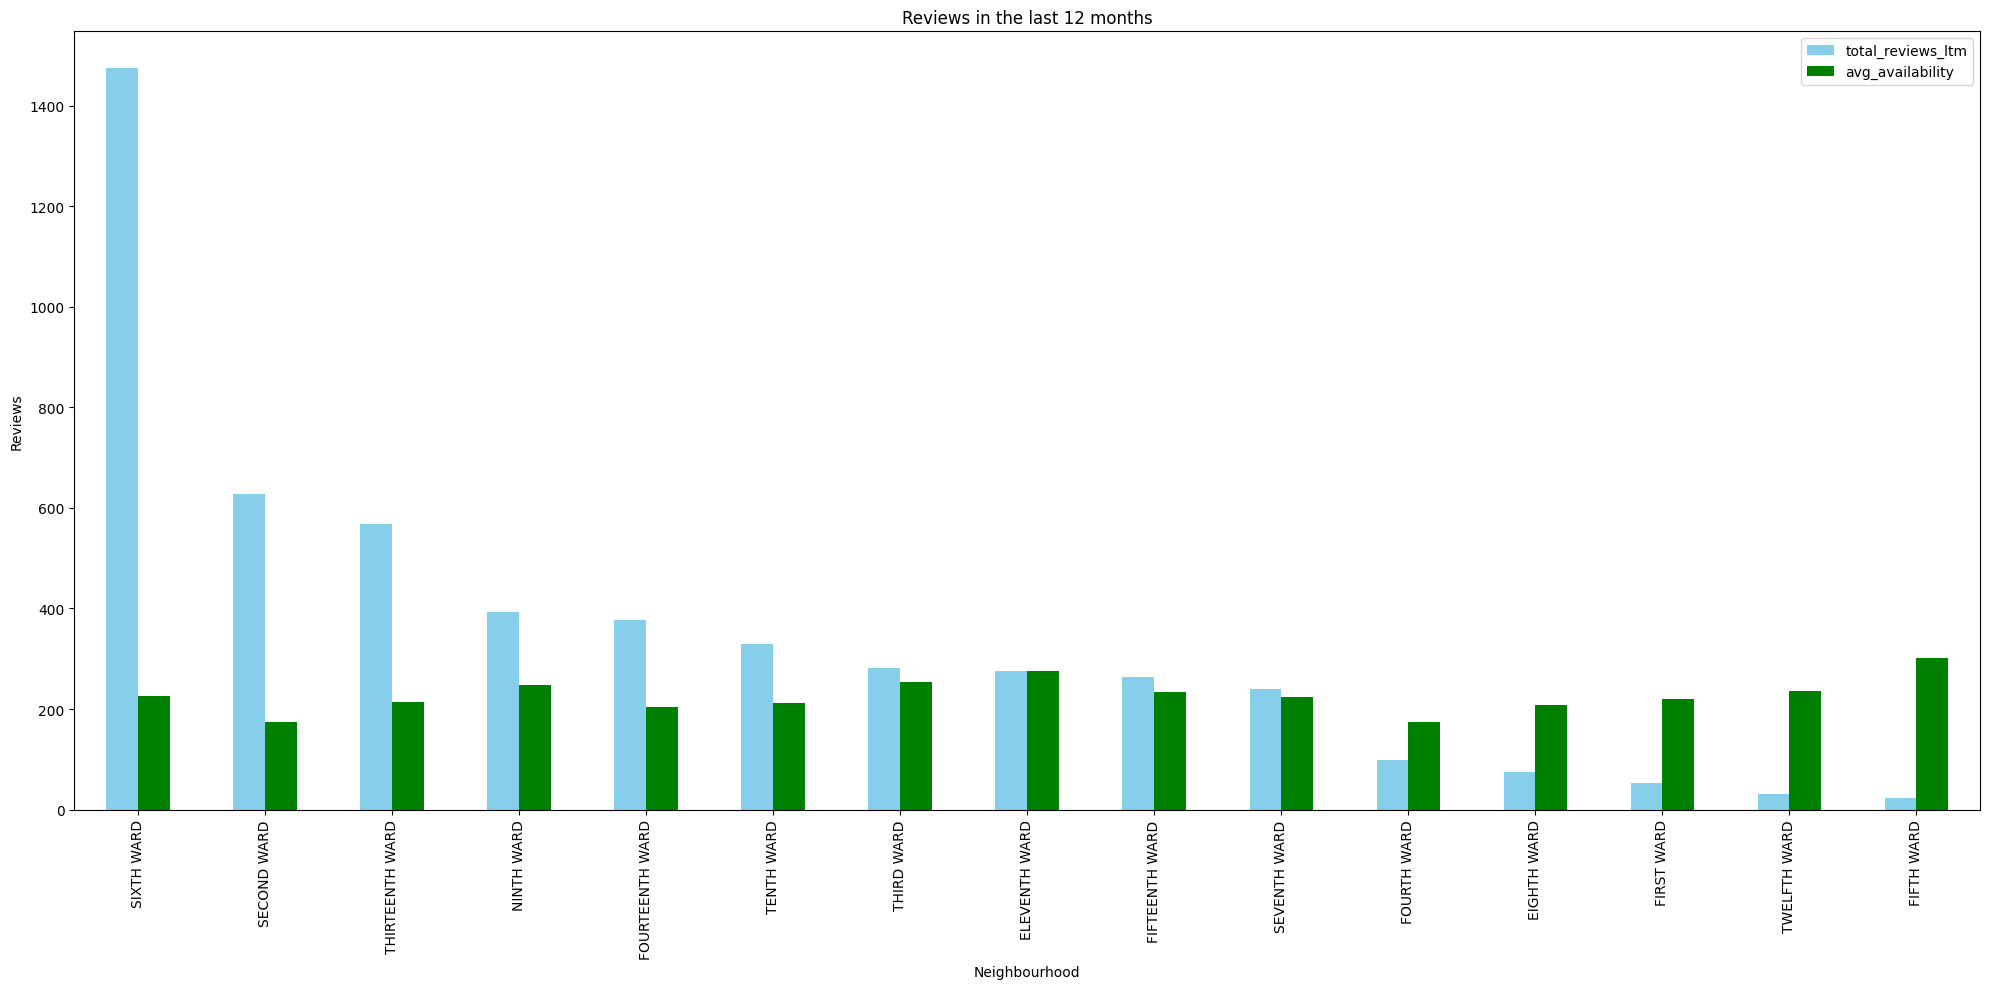

In [36]:
reviews_ltm_price.plot(kind='bar', figsize=(20, 10), color=['skyblue', 'green'])
plt.title('Reviews in the last 12 months')
plt.xlabel('Neighbourhood')
plt.ylabel('Reviews')
plt.tight_layout()
plt.show()

#### Number of Reviews of each Room Type by Price category

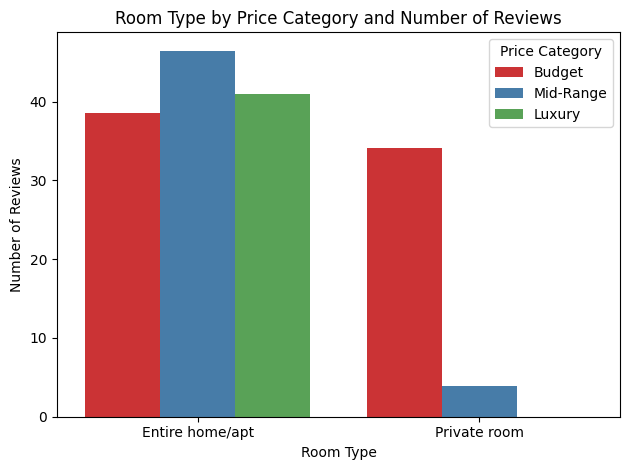

In [37]:
sns.barplot(x='room_type', y='number_of_reviews', hue='price_category', data=updated_df, palette='Set1', errorbar=None)
plt.title('Room Type by Price Category and Number of Reviews')
plt.xlabel('Room Type')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.legend(title='Price Category')
plt.tight_layout()
plt.show()

#### Room Type by Price Category and Availability

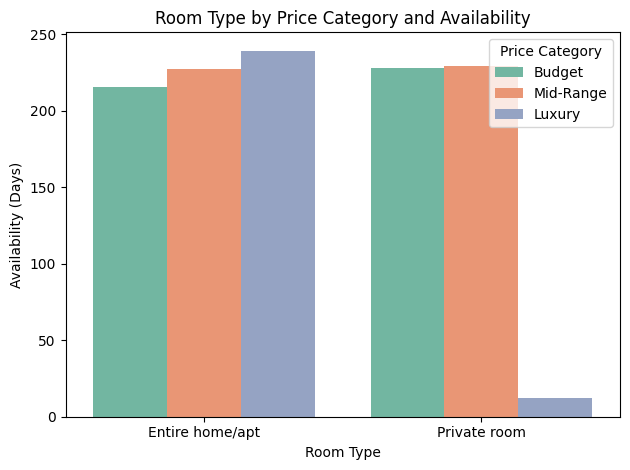

In [38]:
sns.barplot(x='room_type', y='availability_365', data=updated_df, hue='price_category', palette='Set2', errorbar=None)
plt.xlabel('Room Type')
plt.ylabel('Availability (Days)')
plt.title('Room Type by Price Category and Availability')
plt.legend(title='Price Category')
plt.tight_layout()
plt.show()

#### Availability of each Neighbourhood by RoomType (Avg)

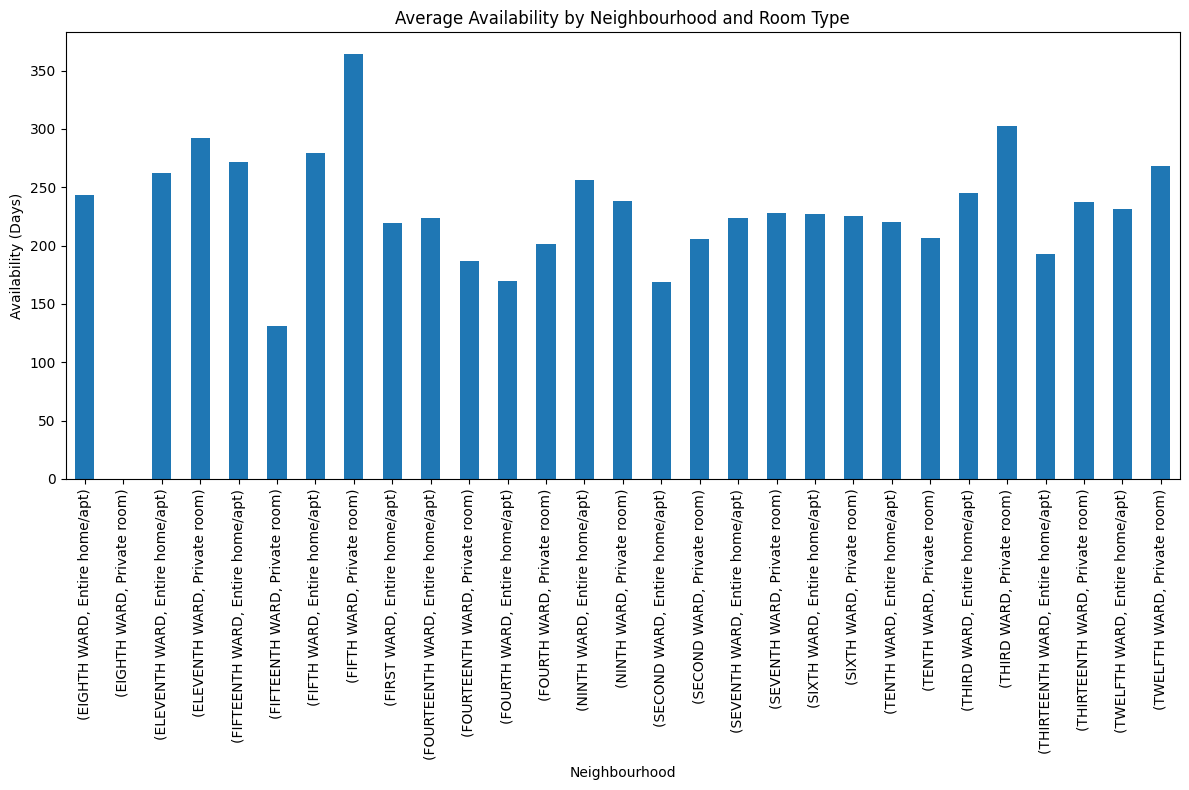

In [39]:
avail_room_stats.plot(kind='bar', figsize=(12, 8))
plt.xlabel('Neighbourhood')
plt.ylabel('Availability (Days)')
plt.title('Average Availability by Neighbourhood and Room Type')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

##### Availability by Neighbourhood (Avg)

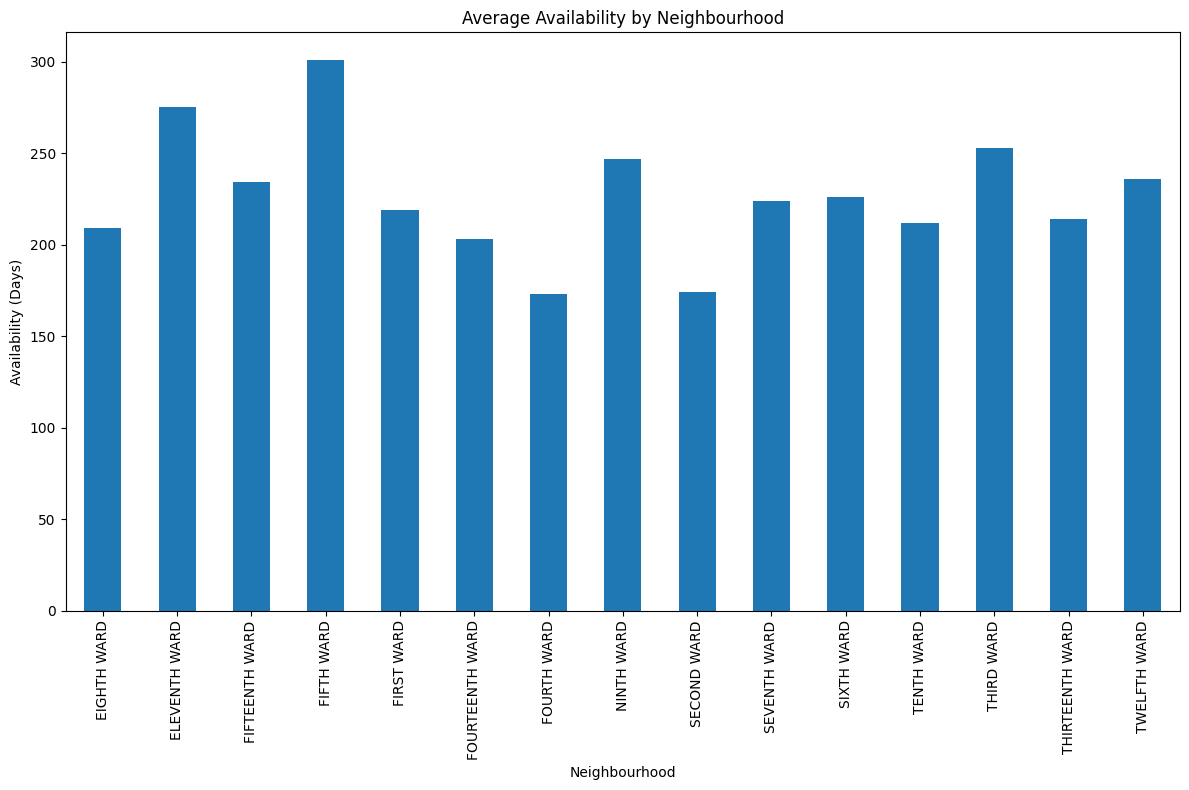

In [40]:
avail_ward_stats.plot(kind='bar', figsize=(12, 8))
plt.xlabel('Neighbourhood')
plt.ylabel('Availability (Days)')
plt.title('Average Availability by Neighbourhood')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Minimum Nights stayed in each ward

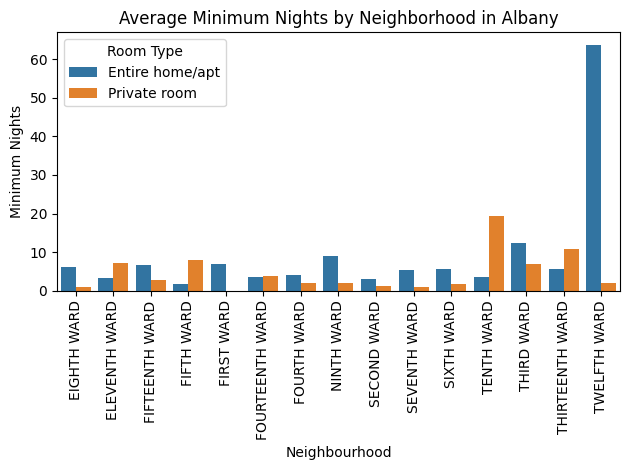

In [41]:
sns.barplot(x='neighbourhood', y='minimum_nights', hue='room_type', data=updated_df, errorbar=None)
plt.title('Average Minimum Nights by Neighborhood in Albany')
plt.xlabel('Neighbourhood')
plt.ylabel('Minimum Nights')
plt.legend(title='Room Type')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Box Plot: Price distribution by room type

C:\Users\IreOluwa\AppData\Local\Temp\ipykernel_14672\3134729182.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='room_type', y='price', data=updated_df, palette='Set2')


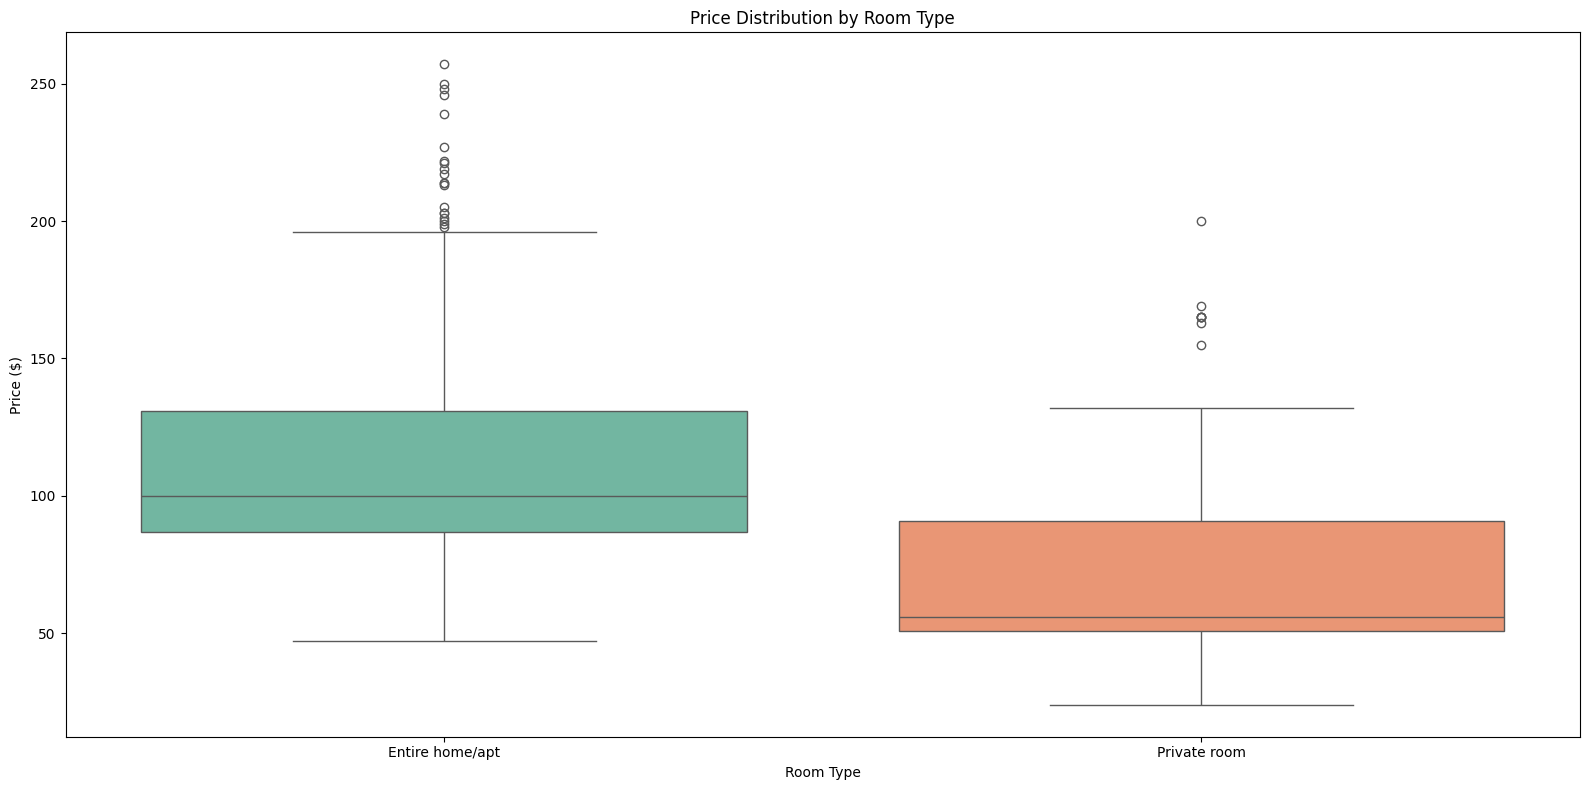

In [42]:
plt.figure(figsize=(16, 8))
sns.boxplot(x='room_type', y='price', data=updated_df, palette='Set2')
plt.title('Price Distribution by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price ($)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

C:\Users\IreOluwa\AppData\Local\Temp\ipykernel_14672\3134729182.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='room_type', y='price', data=updated_df, palette='Set2')


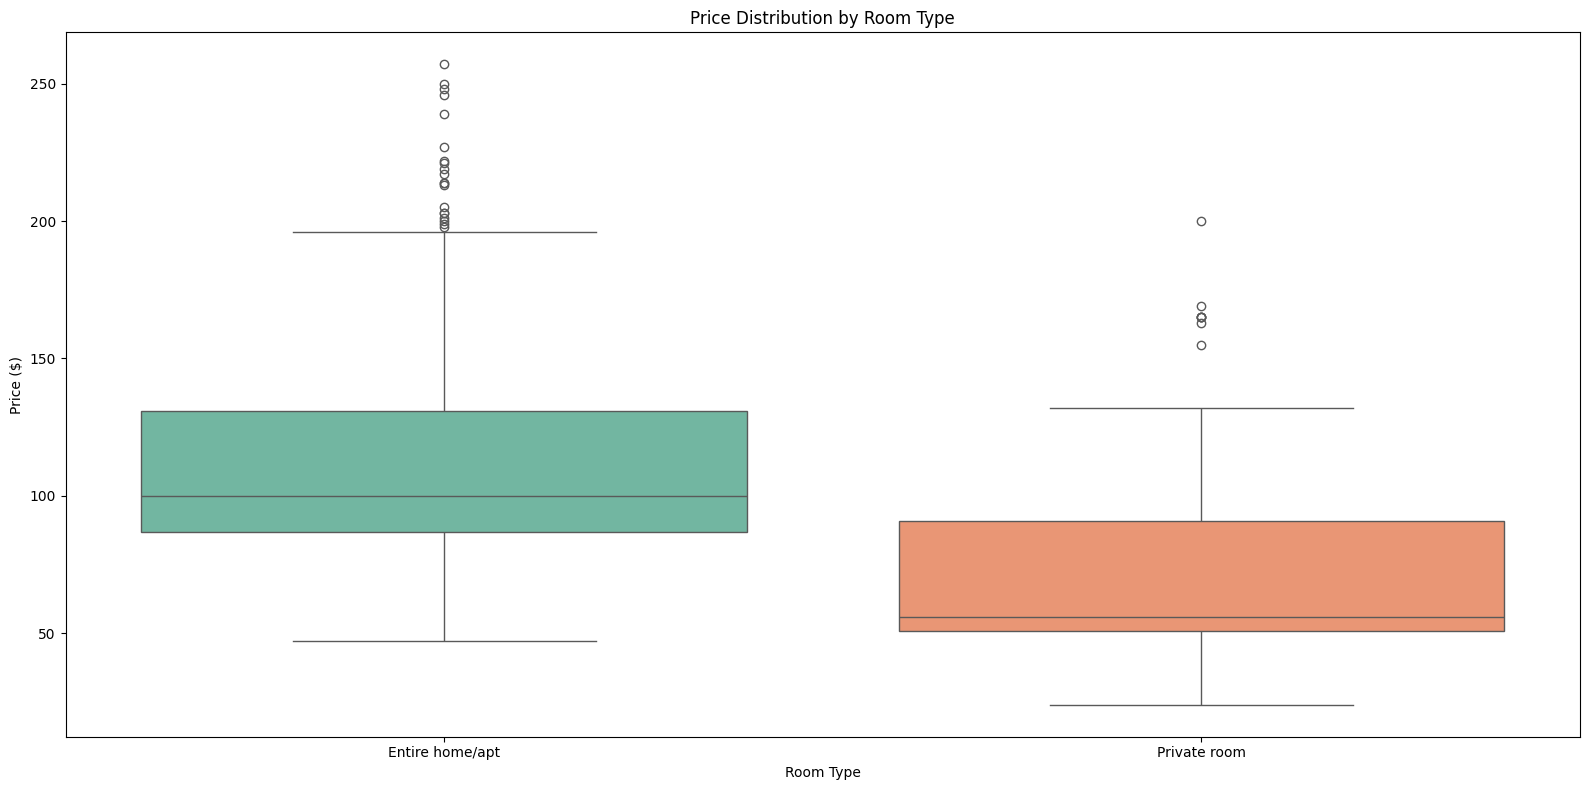

In [43]:
plt.figure(figsize=(16, 8))
sns.boxplot(x='room_type', y='price', data=updated_df, palette='Set2')
plt.title('Price Distribution by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price ($)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Scatter Plot: Price vs. number of reviews

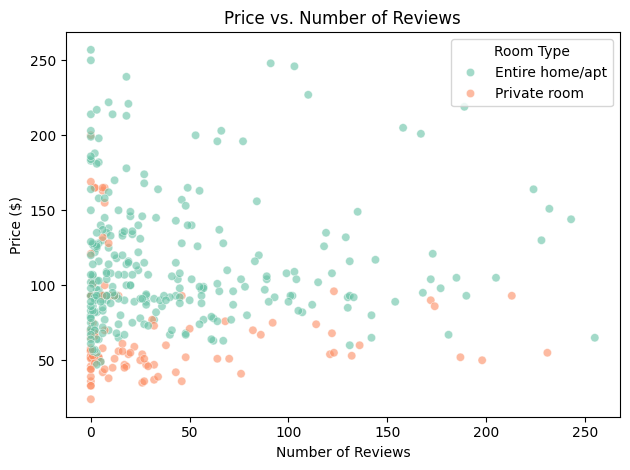

In [44]:
sns.scatterplot(x='number_of_reviews', y='price', data=updated_df, hue='room_type', palette='Set2', alpha=0.6)
plt.title('Price vs. Number of Reviews')
plt.xlabel('Number of Reviews') 
plt.ylabel('Price ($)')
plt.legend(title='Room Type')
plt.tight_layout()
plt.show() 

#### Scatterplot of price vs. availability

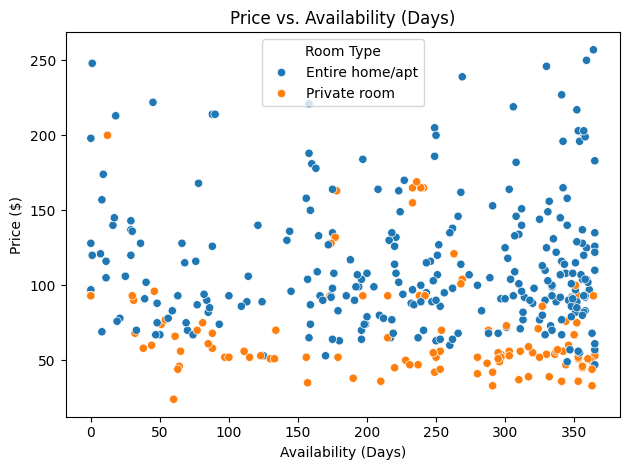

In [45]:
sns.scatterplot(x='availability_365', y='price', hue='room_type', data=updated_df)
plt.title('Price vs. Availability (Days)')
plt.xlabel('Availability (Days)')
plt.ylabel('Price ($)')
plt.legend(title='Room Type')
plt.tight_layout()
plt.show()

#### Minimum Nights vs Number of Reviews

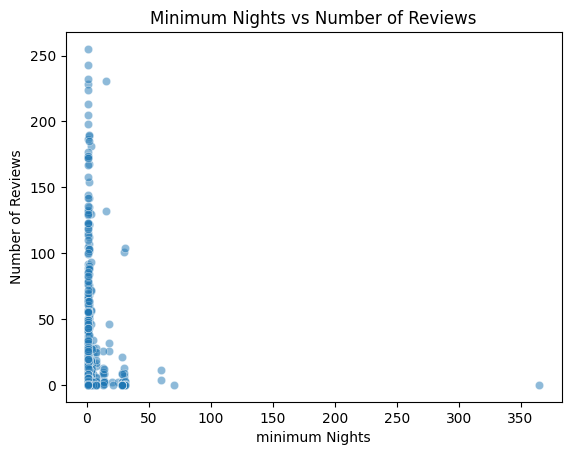

In [46]:
sns.scatterplot(x='minimum_nights', y='number_of_reviews', data=updated_df, alpha=0.5)
plt.title('Minimum Nights vs Number of Reviews')
plt.xlabel('minimum Nights')
plt.ylabel('Number of Reviews')
plt.show()

### Histogram: Distribution of prices.

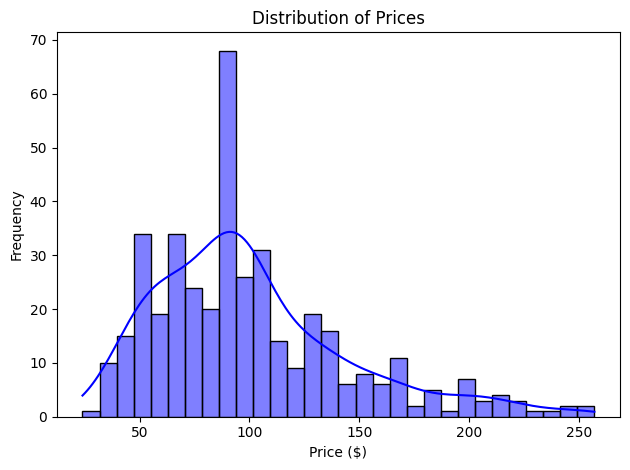

In [47]:
sns.histplot(updated_df['price'], bins=30, kde=True, color='blue')
plt.title('Distribution of Prices')
plt.xlabel('Price ($)') 
plt.ylabel('Frequency')
plt.tight_layout() 
plt.show()

### CountPlot for the Distribution of the price Category

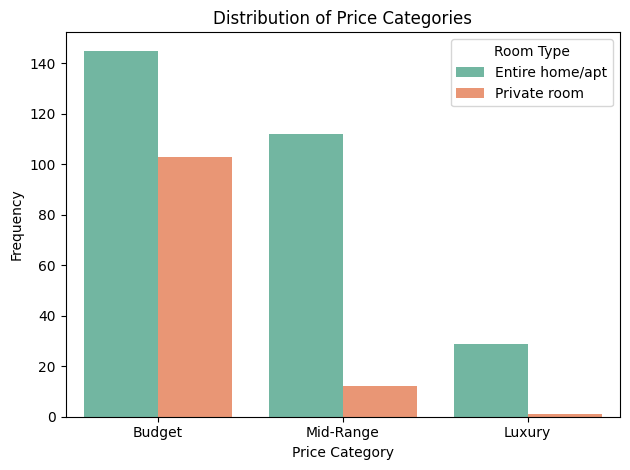

In [48]:
sns.countplot(x='price_category', hue='room_type', data=updated_df, palette='Set2')
plt.title('Distribution of Price Categories')
plt.xlabel('Price Category')
plt.ylabel('Frequency')
plt.legend(title='Room Type')
plt.tight_layout()
plt.show()

#### Price Category Distribution by Neighbourhood

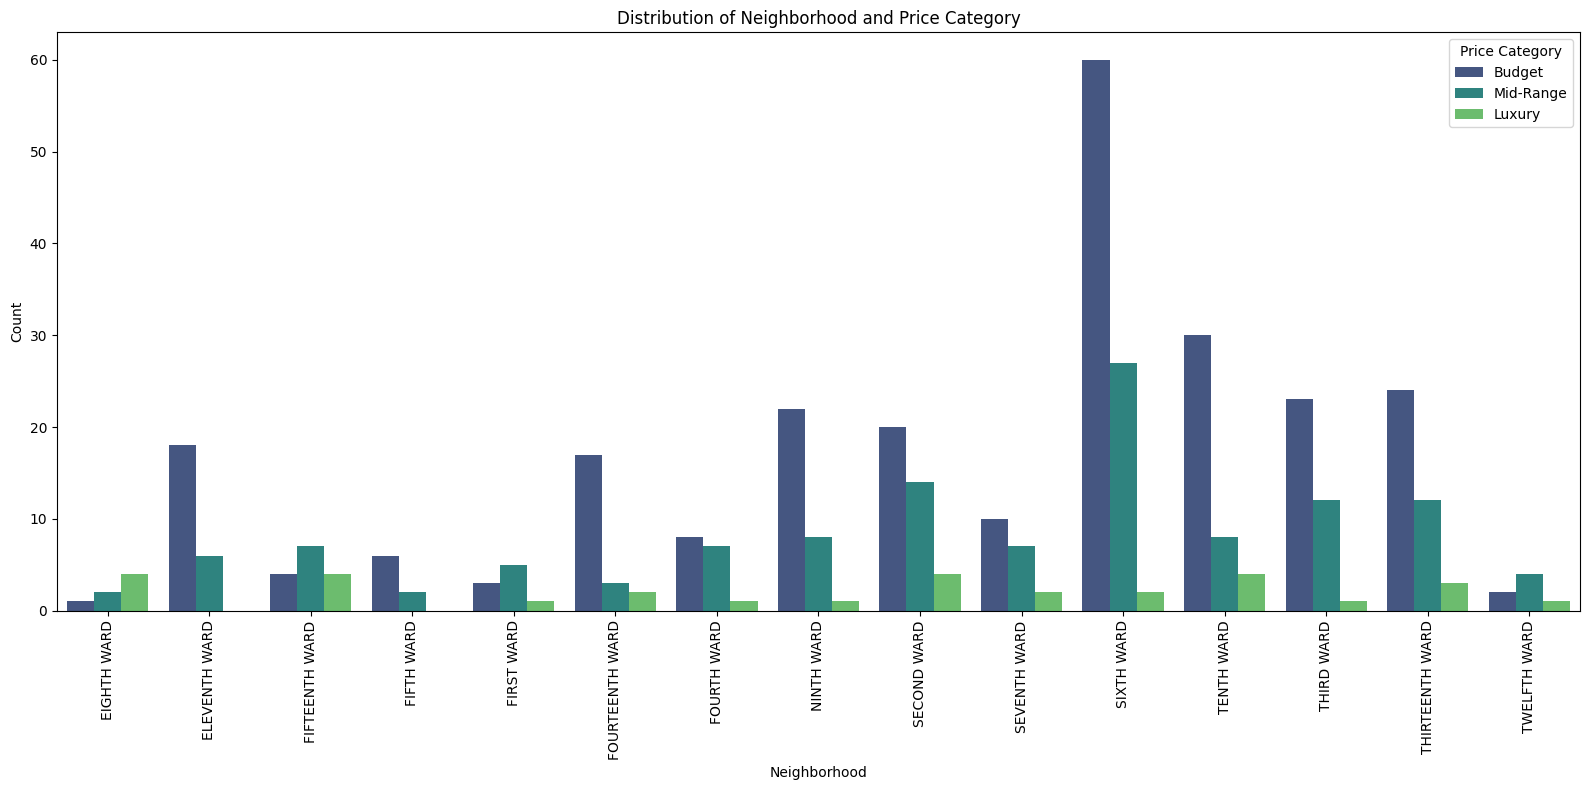

In [49]:
plt.figure(figsize=(16, 8))
sns.countplot(x='neighbourhood', hue='price_category', data=updated_df, palette='viridis')
plt.title('Distribution of Neighborhood and Price Category')
plt.xlabel('Neighborhood')
plt.ylabel('Count')
plt.legend(title='Price Category')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Model for Price Prediction (ML)

### Data Preprocessing

#### Encoding Categorical Data

In [50]:
updated_df_encoded = pd.get_dummies(updated_df, columns=['neighbourhood', 'room_type'], drop_first=True)

#### Features and Target

In [51]:
features = ['number_of_reviews', 'number_of_reviews_ltm', 'availability_365', 'minimum_nights'] + \
           [col for col in updated_df_encoded.columns if col.startswith('neighbourhood_') or col.startswith('room_type_')]
X = updated_df_encoded[features]
y = updated_df_encoded['price']

#### Scale Numeric Features

In [52]:
scaler = StandardScaler()
X[['number_of_reviews', 'number_of_reviews_ltm', 'availability_365', 'minimum_nights']] = scaler.fit_transform(X[['number_of_reviews', 'number_of_reviews_ltm', 'availability_365', 'minimum_nights']])

C:\Users\IreOluwa\AppData\Local\Temp\ipykernel_14672\1995601741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['number_of_reviews', 'number_of_reviews_ltm', 'availability_365', 'minimum_nights']] = scaler.fit_transform(X[['number_of_reviews', 'number_of_reviews_ltm', 'availability_365', 'minimum_nights']])


### Data Splitting

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")

Training set size: (321, 19), Test set size: (81, 19)


### Training

In [54]:
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Evaluation

In [55]:
lr_pred = lr_model.predict(X_test)
rf_pred = rf_model.predict(X_test)

# Evaluation for Linear Regression
print("\nLinear Regression Perfomance:")
print(f"MAE: {mean_absolute_error(y_test, lr_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, lr_pred):.2f}")
print(f"R-Squared: {r2_score(y_test, lr_pred):.2f}")

# Evaluation for Random Forest Regression
print("\nRandom Forest Regression Performance:")
print(f"MAE: {mean_absolute_error(y_test, rf_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, rf_pred):.2f}")
print(f"R-Squared: {r2_score(y_test, rf_pred):.2f}")


Linear Regression Perfomance:
MAE: 32.06
MSE: 1890.39
R-Squared: 0.17

Random Forest Regression Performance:
MAE: 26.09
MSE: 1411.64
R-Squared: 0.38


#### Visualization

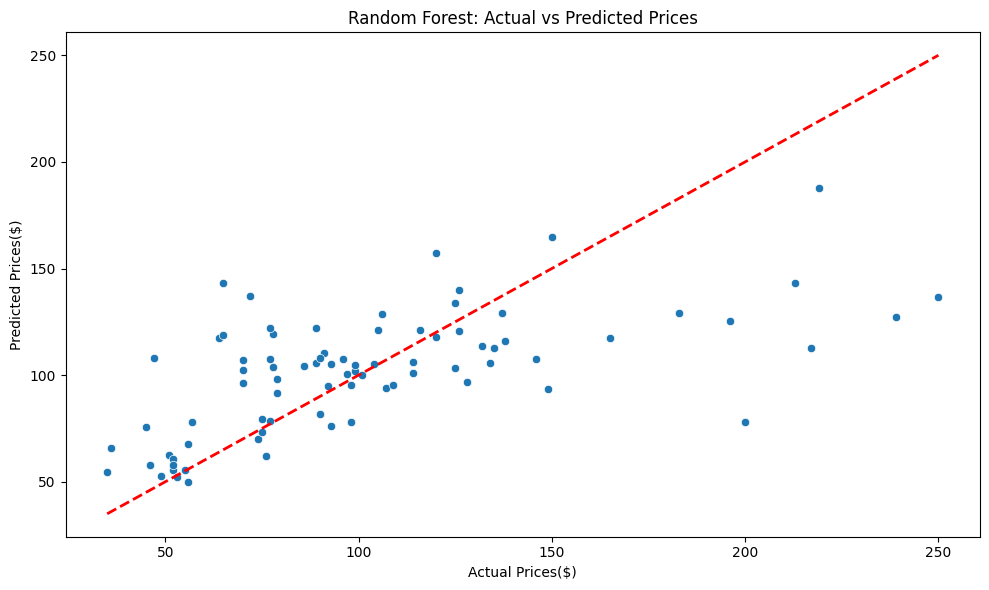

In [56]:
# Scatter plot of Actual vs Predicted Prices

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=rf_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Random Forest: Actual vs Predicted Prices')
plt.xlabel('Actual Prices($)')
plt.ylabel('Predicted Prices($)')
plt.tight_layout()
plt.savefig('actual_vs_predicted_prices.png')
plt.show()

### Feature Importance (Random Forest)

In [57]:
# To analyze which features (eg, 'neighbourhood', 'room_type) most influenced price predictions

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)
feature_importance

,feature,importance
18,room_type_Private room,0.216615
2,availability_365,0.207567
0,number_of_reviews,0.156364
3,minimum_nights,0.117511
1,number_of_reviews_ltm,0.097855
5,neighbourhood_FIFTEENTH WARD,0.034791
13,neighbourhood_SIXTH WARD,0.030392
14,neighbourhood_TENTH WARD,0.029005
4,neighbourhood_ELEVENTH WARD,0.022490
17,neighbourhood_TWELFTH WARD,0.016408


#### Visualize Feature Importance

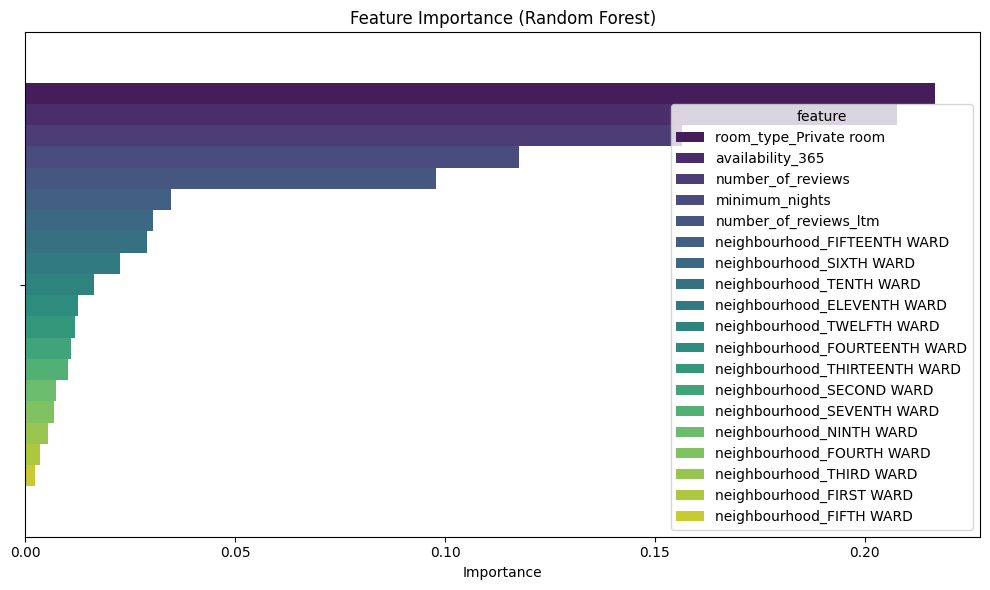

In [58]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', hue='feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

### New Price Prediction Example

In [59]:
new_listing = {
    'neighbourhood': 'FIFTEENTH WARD',
    'room_type': 'Private room', 
    'number_of_reviews': 60, 
    'availability_365': 200, 
    'minimum_nights': 10,
    'number_of_reviews_ltm': 300
}
new_df = pd.DataFrame([new_listing])
new_df_encoded = pd.get_dummies(new_df, columns=['neighbourhood', 'room_type'], drop_first=True)

for col in X.columns:
    if col not in new_df_encoded.columns:
        new_df_encoded[col] = 0 
new_df_encoded = new_df_encoded[X.columns]
new_df_encoded[['number_of_reviews', 'number_of_reviews_ltm', 'availability_365', 'minimum_nights']] = scaler.transform(new_df_encoded[['number_of_reviews', 'number_of_reviews_ltm', 'availability_365', 'minimum_nights']])

new_price = rf_model.predict(new_df_encoded)[0]
print(f"\nPredicted Price for the new listing: ${new_price:.2f}")


Predicted Price for the new listing: $117.15


## Save 

In [60]:
joblib.dump(rf_model, 'airbnb_price_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
feature_columns = X.columns
joblib.dump(feature_columns, 'feature_columns.pkl')

['feature_columns.pkl']

## Insights

In [61]:
with open('Albany Airbnb Prediction.md', 'w') as f:
    f.write("""
# Albany Airbnb Price Prediction Analysis

**Objective**: Predict Airbnb listing prices in Albany using various features such as Neighbourhood, Room Type, Reviews and Availabilty.

**Features**:
- Neighbourhood(e.g, SIXTH WARD, FIFTEENTH WARD)
- Room Type (e.g, entire home/apt, private room)
- Number of Reviews, Reviews LTM, Availability
- Minimum Nights.
            
**Model**: Random Forest Regressor
- MAE (Mean Asolute Error): {:.2f}
- R-Squared: {:.2f}
            
**Insights**: 
- The Private Room in the SEVENTH WARD has very budget friendly listing with an average price of $50 which explains why it is one of the most reviewed listing with an average of 198 reviews.
- The most expensive listing is in the EIGHTH WARD with an average price of $199.83 for an entire home/apt. Also, the private Room has the highest number of reviews despite having a high average price of $93.
- Room type, specifically the Private Room strongly influences price, with Entire home/apt being pricier.
- The first ward didn't sell any private room.
- The NUMBER OF REVIEWS has a strong negative correlation with the MINIMUM NIGHT spent in each rooms, which means that wards with high number of reviews have low minimum nights spent.
- The private room of both the FIRST and SIXTH ward have zero availability.
- The SIXTH WARD has the highest BUDGET and  MID RANGE price category frequency in the neighbourhood which means the average customer prefers rooms in the SIXTH WARD.
- The Total reviews for each ward in the last 12 months is slightly negatively correlated with the average availability of each ward as ward with higher total reviews in the last 12 months tend to have low availability and wards with higher availability tend to have lower total reviews in the last 12 months. For example: The FIFTH ward has a very low total reviews in the last 12 months but a very high availaility in fact, it is the most available ward of 365 days.
                  
**Visualizations**:
- Actual vs Predicted Prices: 'actual_vs_predicted_prices.png'
- Feature Importance: 'feature_importance.png'
""".format(mean_absolute_error(y_test, rf_pred), r2_score(y_test, rf_pred)))

### Correlation 

1. The NUMBER OF REVIEWS and PRICE are weakly positively correlated i.e. increase in PRICE results in a slight increase in number of reviews.
2. The NUMBER OF REVIEWS has a strong negative correlation with the MINIMUM NIGHT spent in each rooms, which means that wards with high number of reviews have low minimum nights spent.
3. The PRICE and AVAILABILITY are fairly negatively correlated with correlation value of -0.08 which shows that the more expensive a WARD is, the less available the ward is. 

### Price

1. The most Expensive ward in the neighborhood is the EIGHTH WARD, with an average price of $188.57, while the cheapest ward in the neighbourhood is the ELEVENTH WARD with an average price of $71.96.
2. The most cheapest ward in the neighbourhood with respect to room type is the SEVENTH WARD (Private room) with an average price of $50, while the most expensive ward in the neghbourhood with respect to room type is the EIGHTH WARD (Entire home/apt) with an average price of $199.83.
3. The most expensive Budget room is in the FOURTEENTH WARD (Entire home/apt) with a price of $100, while the cheapest Budget room is in the NINTH WARD (Private room) with a price of $24.
4. The most expensive Mid-Range room is in the SECOND WARD (Entire home/apt) $174, while the cheapest Mid-Range is in the SIXTH WARD (Entire home/apt) with a price $101.
5. The most expensive Luxury room is in the EIGHTH WARD (Entire home/apt) with a price of $257, while the cheapest Luxury room is in the TENTH WARD (Entire home/apt) with a price of $178.

### Wards (Neighborhood)

1. The first ward didn't sell any private room
2. The rooms in the EIGHT WARD are the most reviewed in the neighbourhood, while the rooms in the TWELVETH WARD are the least reviewed in the neighbourhood which may mean that customers are more likely to purchase rooms in the EIGHT WARD and are least likely to purchase rooms in the TWELVETH WARD.
3. The SIXTH WARD has the highest BUDGET and  MID RANGE price category frequency in the neighbourhood which means the average customer prefers rooms in the SIXTH WARD. 
4. The TENTH WARD has the highest luxury purchase in the neighbourhood which means customers prefer the LUXURY rooms in the TENTH WARD.
5. The FIFTH ward is available throughout the year (365 days) making it the most available ward.
6. The Total reviews for each ward in the last 12 months is slightly negatively correlated with the average availability of each ward as ward with higher total reviews in the last 12 months tend to have low availability and wards with higher availability tend to have lower total reviews in the last 12 months. For example: The FIFTH ward has a very low total reviews in the last 12 months but a very high availaility.

### Room Type

1. The ENTIRE HOME/APT, also the PRIVATE ROOM, specifically the BUDGET category is the most reviewed ROOM TYPE, while the MID-RANGE price category for both the ENTIRE HOME/APT and the PRIVATE ROOM is the least reviewed ROOM TYPE. This insight shows that customers review the cheap rooms more than they do the others which can also mean that customers are more likely to purchase the cheaper rooms since it is easily affordable.
2. The LUXURY price category for the PRIVATE ROOM isn't reviewed at all which could mean that customers are least likely to purchase the LUXURY PRIVATE ROOM possibly due to it's high costs.
3. The LUXURY price category for the ENTIRE HOME/APT is the second most reviewed ROOM TYPE which means that customers are more likely to purchase the ENTIRE HOME APT whether or not it is expensive compared to the private room. A recommendation for this is that the ENTIRE HOME/APT should be invested in more as it brings more returns.
4. The private room of both the FIRST and SIXTH ward have zero availability.